In [1]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
from linear_ssm import StateSpace_EM
from nonlinear_ssm import NonLinearKalmanSmoother, NonLinearStateSpace_EM
import factors

In [114]:
T = 1000
trange = numpy.arange(T)
Dx = 20
Dz = 10
X = numpy.empty((T,Dx))
for dx in range(Dx):
    X[:,dx] = numpy.sin(trange / 10 * numpy.random.rand())
noise_x = .2
noise_z = .1
X += noise_x * numpy.random.randn(*X.shape)

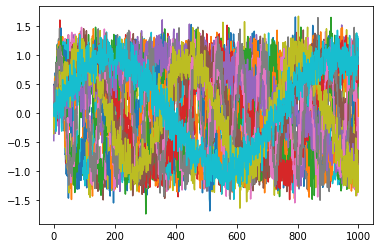

In [115]:
pyplot.plot(X)

In [119]:
Dk = 10
Dphi = Dk + Dz
nlssm = NonLinearStateSpace_EM(X, Dz, Dk=Dk, noise_z=.1)

In [120]:
nlssm.run_em()

Iteration 1 - llk=-61569.0
Iteration 2 - llk=-15243.8
Iteration 3 - llk=-10422.0
Iteration 4 - llk=-7826.0
Iteration 5 - llk=-6933.2
Iteration 6 - llk=-6515.0
Iteration 7 - llk=-6147.1
Iteration 8 - llk=-5932.2
Iteration 9 - llk=-5842.0
Iteration 10 - llk=-5804.4
Iteration 11 - llk=-5787.0
Iteration 12 - llk=-5778.1
Iteration 13 - llk=-5773.3
Iteration 14 - llk=-5770.8
Iteration 15 - llk=-5769.8
Iteration 16 - llk=-5769.7


[-61569.04550567486,
 -15243.779900491823,
 -10422.030702569014,
 -7825.994773745668,
 -6933.197937243215,
 -6515.010567541716,
 -6147.144001327513,
 -5932.168614038551,
 -5842.005903695867,
 -5804.440461120618,
 -5787.02294761741,
 -5778.085329136608,
 -5773.275208277914,
 -5770.783780292451,
 -5769.753540095311,
 -5769.723716660345]

In [101]:
nlssm.A[:,:2]

array([[0.97231553, 0.00618102],
       [0.00363113, 0.98770408]])

In [56]:
nlssm.ks.forward_path()
nlssm.ks.backward_path()

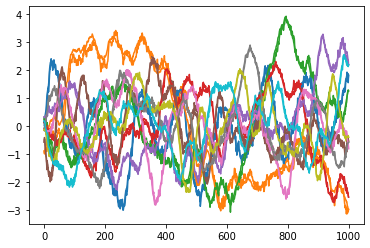

In [121]:
pyplot.plot(nlssm.ks.filter_density.mu)
pyplot.plot(nlssm.ks.smoothing_density.mu)

In [43]:
Ezz = nlssm.ks.smoothing_density.integrate('xx')
# E[zz']
Ezz_sum = numpy.sum(Ezz[1:], axis=0)
# E[z f(z)'] A'
v_joint = numpy.zeros([Dk, int(2 * Dz)])
v_joint[:,Dz:] = nlssm.ks.state_density.k_func.v
nu_joint = numpy.zeros([Dk, int(2 * Dz)])
nu_joint[:,Dz:] = nlssm.ks.state_density.k_func.nu
joint_k_func = factors.OneRankFactor(v=v_joint, nu=nu_joint, ln_beta=nlssm.ks.state_density.k_func.ln_beta)
Ezz_cross = nlssm.ks.twostep_smoothing_density.integrate('xx')[:,Dz:,:Dz]
Ezk = nlssm.ks.twostep_smoothing_density.multiply(joint_k_func).integrate('x').reshape((T,(2*Dz),Dk))[:,:Dz]
Ezf = numpy.concatenate([Ezz_cross, Ezk], axis=2)
EzfA = numpy.einsum('abc,dc->bd', Ezf, nlssm.A)
# E[z]b'
Ezb = numpy.sum(nlssm.ks.smoothing_density.integrate('x')[1:,None] * nlssm.b[None,:,None], axis=0)
# A E[f(z)] b'
Ez = numpy.sum(nlssm.ks.smoothing_density.integrate('x')[:-1], axis=0)
Ek = numpy.sum(nlssm.ks.smoothing_density.multiply(nlssm.ks.state_density.k_func).integrate().reshape((T+1,Dk))[:-1], axis=0)
Ef = numpy.concatenate([Ez, Ek])
AEfb = numpy.dot(nlssm.A, Ef)[:,None] * nlssm.b[None]
# A E[f(z)f(z)'] A'
Ekk = nlssm.ks.smoothing_density.multiply(nlssm.ks.state_density.k_func).multiply(nlssm.ks.state_density.k_func).integrate().reshape((T+1, Dk, Dk))
Ekz = nlssm.ks.smoothing_density.multiply(nlssm.ks.state_density.k_func).integrate('x').reshape((T+1, Dk, Dz))
Eff = numpy.empty((Dphi, Dphi))
Eff[:Dz,:Dz] = numpy.sum(Ezz[:-1], axis=0)
Eff[Dz:,Dz:] = numpy.sum(Ekk[:-1], axis=0)
Eff[Dz:,:Dz] = numpy.sum(Ekz[:-1], axis=0)
Eff[:Dz,Dz:] = Eff[Dz:,:Dz].T
AEffA = numpy.dot(numpy.dot(nlssm.A, Eff), nlssm.A.T)

In [60]:
.5 * numpy.trace(numpy.dot(nlssm.Qz_inv, Ezz_sum - EzfA - EzfA.T + AEffA - Ezb - Ezb.T + AEfb + AEfb.T + T * nlssm.b[:,None] * nlssm.b[None]))

996.6238018249726

In [63]:
Ez = nlssm.ks.smoothing_density.integrate('x')[1:]
Ek = nlssm.ks.smoothing_density.multiply(nlssm.ks.state_density.k_func).inte

array([[-0.75573386, -0.22415488],
       [-0.69667929, -0.20669239],
       [-0.62898852, -0.29529102],
       ...,
       [ 1.52864635,  0.30101948],
       [ 1.55239161,  0.11893438],
       [ 1.60111151, -0.09954937]])

In [79]:
nlssm.update_A()

[[ 672.2842988     4.89675173 -107.35522866  210.99244799  -17.46340649
  -145.8613493   107.11333129   44.95466978 -182.41343711    3.97037461
  -140.22524034    4.39522718]
 [   4.89675173  635.53902296  147.38031445  -35.47462792   -7.21848967
    59.49896114   12.34602302   21.6137268   130.61611292    5.97620937
   181.52343089   18.08285617]
 [-107.35522866  147.38031445  564.91936083  263.6836689   487.04436808
   376.94066368  595.82210724  518.12807017  436.54570186  420.55910534
   307.49316441  637.89157151]
 [ 210.99244799  -35.47462792  263.6836689   264.714641    294.04401251
   134.3943808   411.94957242  330.53481079  149.18959402  259.3884596
    96.4462779   384.9962001 ]
 [ -17.46340649   -7.21848967  487.04436808  294.04401251  557.70095998
   328.99743425  600.42248785  568.32181143  354.72486848  503.31176767
   238.97569951  619.05696019]
 [-145.8613493    59.49896114  376.94066368  134.3943808   328.99743425
   332.28016741  370.99888809  347.08943902  328.52740

In [80]:
nlssm.update_Qz()

[[-1.59161573e-12  8.88178420e-16]
 [ 0.00000000e+00  6.82121026e-13]]


In [81]:
nlssm.A

array([[ 9.94991058e-01, -8.06975954e-04,  1.14275241e-03,
        -7.80214998e-03,  6.33445932e-04, -1.00933669e-04,
         6.37216472e-03, -2.94651048e-03, -9.88330264e-04,
         1.94349294e-04,  1.43498233e-03, -9.07273515e-04],
       [-1.08734690e-03,  9.93895242e-01, -5.92374192e-03,
         1.47620704e-03,  3.68588624e-04, -3.43572614e-04,
         1.64748453e-03, -1.86962301e-03,  2.20725624e-03,
        -1.31995224e-06, -6.55511764e-04,  3.44748422e-03]])

In [82]:
nlssm.Qz

array([[9.93186185e-03, 1.01763781e-06],
       [1.01763781e-06, 9.93036470e-03]])

In [93]:
nlssm.update_b()

(2, 12) (1001, 12)


In [238]:
phi = nlssm.ks.smoothing_density.slice(range(1,T+1))
backward_densities = nlssm.ks.state_density.affine_conditional_moment_matching(nlssm.ks.filter_density.slice(range(T)))

In [230]:
Ezz_cross

array([[[0.55712881, 0.0040491 ],
        [0.0040491 , 0.56085037]],

       [[0.55830617, 0.00412937],
        [0.00413026, 0.56210216]],

       [[0.55946583, 0.00421133],
        [0.00421281, 0.56334428]],

       ...,

       [[1.23835564, 0.00870932],
        [0.00878537, 1.29045812]],

       [[1.24797538, 0.00878942],
        [0.00883716, 1.3001217 ]],

       [[1.25774556, 0.00883887],
        [0.00886936, 1.30989938]]])

In [94]:
nlssm.b

array([5.01952816e-06, 2.97670435e-06])

In [89]:
nlssm.A

array([[ 9.94991058e-01, -8.06975954e-04,  1.14275241e-03,
        -7.80214998e-03,  6.33445932e-04, -1.00933669e-04,
         6.37216472e-03, -2.94651048e-03, -9.88330264e-04,
         1.94349294e-04,  1.43498233e-03, -9.07273515e-04],
       [-1.08734690e-03,  9.93895242e-01, -5.92374192e-03,
         1.47620704e-03,  3.68588624e-04, -3.43572614e-04,
         1.64748453e-03, -1.86962301e-03,  2.20725624e-03,
        -1.31995224e-06, -6.55511764e-04,  3.44748422e-03]])